In [1]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt

# Poulson Algorithm 1

In [2]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A


# Poulson Algorithm 3/4

In [3]:
def sampling_algorithm_3(K):
    
    block_size = 32
    n = len(K)

    sample = []
    A = K.copy()
    
    for j in range(n):
        
        bsize = min(block_size, n-j)
        
        J_1 = slice(j, bsize + j)
        J_2 = slice(j + bsize, n)
                
        sub_sample, A[J_1,J_1] = sampling_algorithm_1(A[J_1,J_1])
        
        for s in sub_sample:
            sample.append(s + j)
            
        _, tril, triu  = linalg.lu(A[J_1,J_1])
        
        A[J_2,J_1] = np.dot(
            A[J_2,J_1],
            linalg.inv(triu),
        )
        
        A[J_1,J_2] = np.dot(
            linalg.inv(tril), 
            A[J_1,J_2],
        )
         
        A[J_2,J_2] -= np.dot(A[J_2,J_1], A[J_1,J_2])
        
        j += bsize
        
    return sample, A

# Uniform Spanning Trees

C:\Users\samki\AppData\Local\Temp\ipykernel_21784\2504094098.py:9: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(G).todense()


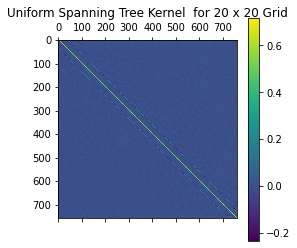

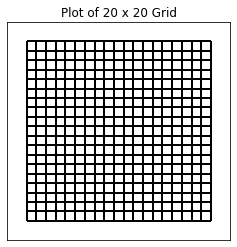

In [4]:
grid_dims = 20

# Create a grid with dimension grid_dims x grid_dims
G = grid_graph(dim=(grid_dims, grid_dims))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
weights = [2 for u,v in G.edges()]

# The vertex-edge incidence matrix
A = nx.incidence_matrix(G).todense()
A_T = A.transpose()
AA_T = A.dot(A_T)

# Compute the kernel K from the vertex-edge incidence matrix 
K = A_T.dot(linalg.inv(AA_T)).dot(A)

plt.matshow(np.array(K))
plt.colorbar()
plt.title("Uniform Spanning Tree Kernel  for %d x %d Grid" % (grid_dims, grid_dims))

plt.figure(3,figsize=(4,4)) 
plt.title("Plot of %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
)
plt.show()

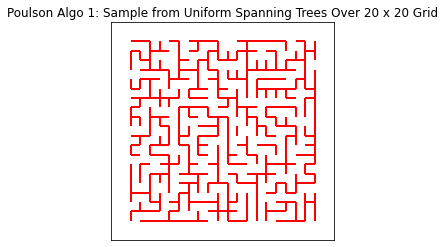

In [5]:
# Sample from the point process

samples,_ = sampling_algorithm_1(K)

plt.figure(3,figsize=(4,4)) 
plt.title("Poulson Algo 1: Sample from Uniform Spanning Trees Over %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
    edgelist = [edge for i,edge in enumerate(G.edges()) if i in samples],
    edge_color='red'
)
plt.show()

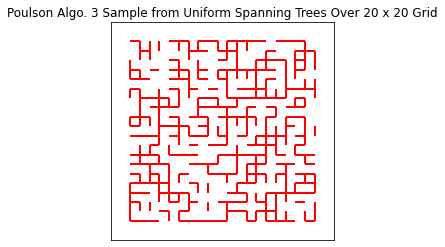

In [6]:
# Sample from the point process

samples,_ = sampling_algorithm_3(K)

plt.figure(3,figsize=(4,4)) 
plt.title("Poulson Algo. 3 Sample from Uniform Spanning Trees Over %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
    edgelist = [edge for i,edge in enumerate(G.edges()) if i in samples],
    edge_color='red'
)
plt.show()

# Discretized Sine Process

[7.170e-01 1.451e-01 5.400e-03 1.000e-04 0.000e+00 0.000e+00 0.000e+00]


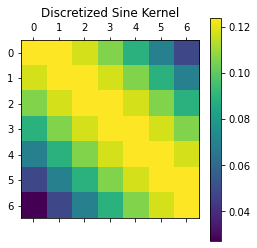

[]


In [7]:
k=3

def compute_sine_kernel_entry(m,l):
    try: 
        upper = sici(1/(2**k)*math.pi*(m-l-1))[0]
    except:
        upper = sici(1/(2**k)*math.pi*(m-l-1))
    
    try:
        lower = sici(1/(2**k)*math.pi*(m-l))[0]
    except:
        lower = sici(1/(2**k)*math.pi*(m-l))
    
    return 1/(-math.pi)*(upper-lower)


sine_K = np.array([[compute_sine_kernel_entry(m,l) for m in range(2**k-1)] for l in range(2**k-1)])

print(np.around(np.linalg.eig(sine_K)[0].real,4))

plt.matshow(np.array(sine_K))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(sine_K)
print(samples)

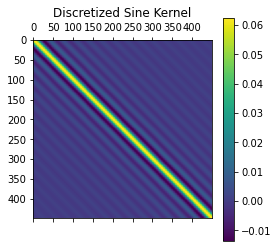

28


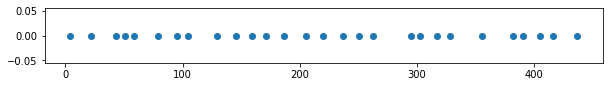

In [8]:
def sine_kernel(x,y):
    return math.sin(math.pi*(x-y))/(math.pi*(x-y))

interval_size = 30
k=4

kernel = np.array([[sine_kernel(m/(2**k),l/2**k) if m != l else 1 for m in range(interval_size*(2**k-1))] for l in range(interval_size*(2**k-1))])/(2**k)

# print(np.around(np.linalg.eig(kernel)[0].real,4))

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(kernel)
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))

[-2.         -1.69230769 -1.38461538 -1.07692308 -0.76923077 -0.46153846
 -0.15384615  0.15384615  0.46153846  0.76923077  1.07692308  1.38461538
  1.69230769  2.        ]



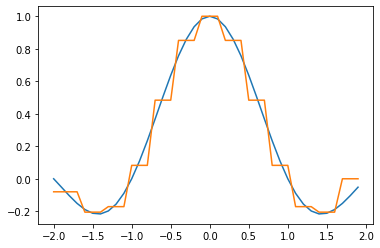

C:\Users\samki\AppData\Local\Temp\ipykernel_21784\3540527084.py:36: RuntimeWarning: invalid value encountered in true_divide
  Z = np.sin(math.pi*(X-Y))/(math.pi*(X-Y))
C:\Users\samki\AppData\Local\Temp\ipykernel_21784\3540527084.py:46: RuntimeWarning: invalid value encountered in true_divide
  Z_disc = np.sin(math.pi*(X-Y))/(math.pi*(X-Y))


(0.0, 1.0)

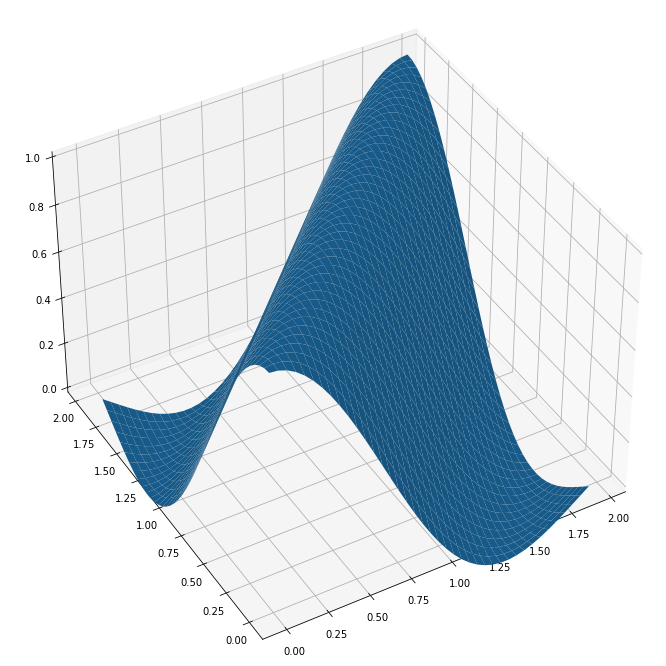

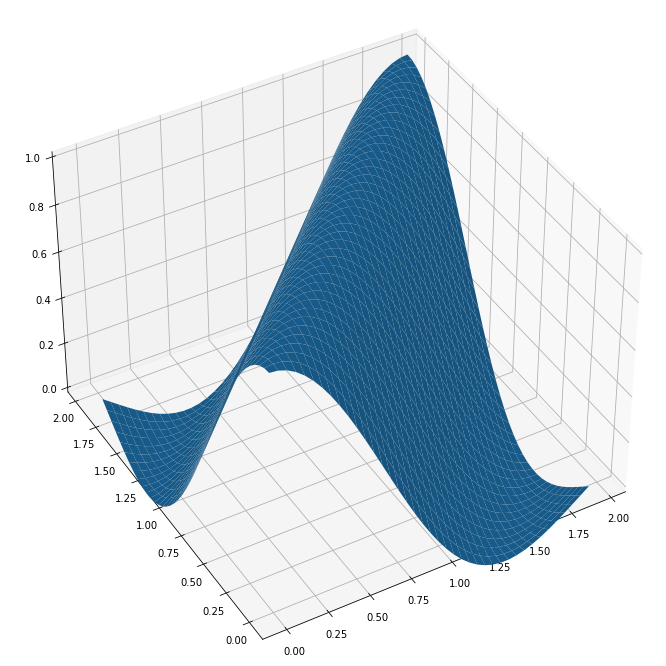

In [380]:
from matplotlib import cm

k = 3
a=-2
b=2

x = np.arange(a,b,.1)
y = np.sin(math.pi*x)/(math.pi*x)

def discretize(points, a, b, partitions):
    bins = [a]+np.linspace(a,b,partitions)+[b]
    return np.piecewise(points, 
                       ([(points <= bins[0])] +
                       [((points >= bins[i]) & (points <= bins[i + 1])) for i in range(len(bins)-2)] +
                       [(points >= bins[len(bins) - 1])]), 
                       [0]+([np.sin(math.pi * ((bins[i]+bins[i+1])/2))/(math.pi * ((bins[i]+bins[i+1])/2)) if (bins[i]+bins[i+1])/2 != 0.0 else 1 for i in range(len(bins)-1)])+[0],
                      )

plt.plot(x,y)
plt.plot(x,discretize(x, a, b, 14))

samples = np.arange(-4,4,.1)


print(
     )

plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12,12))

X = np.arange(0, 2, 0.05)
Y = np.arange(0, 2, 0.05)
X, Y = np.meshgrid(X, Y)
Z = np.sin(math.pi*(X-Y))/(math.pi*(X-Y))
np.fill_diagonal(Z,1)

# Plot the surface.
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)

ax.view_init(40, -120)
ax.set_zlim(0, 1)

fig2, ax2 = plt.subplots(subplot_kw={"projection": "3d"},figsize=(12,12))
Z_disc = np.sin(math.pi*(X-Y))/(math.pi*(X-Y))

ax2.plot_surface(X, Y, Z, rstride=1, cstride=1)

ax2.view_init(40, -120)
ax2.set_zlim(0, 1)


# Sanity Check With GUE Eigenvalues

True


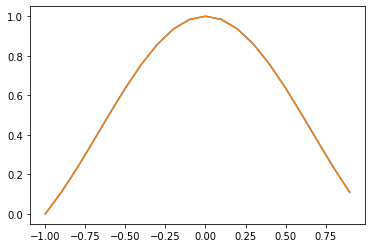

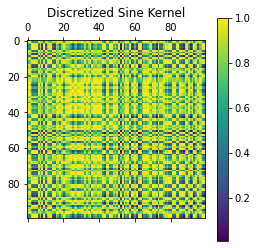

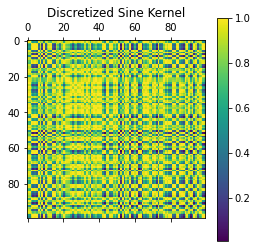

Original function positive definite: True
Discretized function positive definite: False


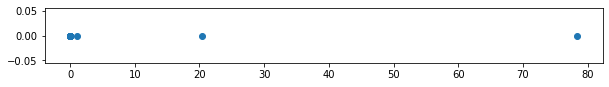

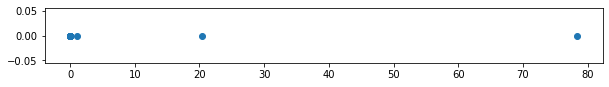

In [759]:
sample_size = 100
partitions = 100000

s = np.random.uniform(-0.5,0.5, sample_size)

matrix = np.array([[np.sin(math.pi*(s[i]-s[j]))/(math.pi*(s[i]-s[j])) if i != j else 1 for i in range(sample_size)] for j in range(sample_size)])

def discretize(points, a, b, partitions):
    bins = [a]+np.linspace(a,b,partitions)+[b]

    return np.piecewise(points, 
                       ([(points <= bins[0])] +
                       [((points >= bins[i]) & (points <= bins[i + 1])) for i in range(len(bins)-2)] +
                       [(points >= bins[len(bins) - 1])]), 
                       [0]+([np.sin(math.pi * ((bins[i]+bins[i+1])/2))/(math.pi * ((bins[i]+bins[i+1])/2)) if (bins[i]+bins[i+1])/2 != 0.0 else 1 for i in range(len(bins)-1)])+[0],
                       )

x = np.arange(-1,1,.1)
y = np.sin(math.pi*x)/(math.pi*x)


plt.plot(x,y)
plt.plot(x,discretize(x, -1, 1, partitions))

input_matrix = np.array([[s[i]-s[j] for i in range(sample_size)] for j in range(sample_size)])


discretized = discretize(input_matrix, -1, 1, partitions)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


print(check_symmetric(discretized))
plt.matshow(matrix)
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

#print(matrix)
#print("Space")

#print(discretized)
plt.matshow(discretized)
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

eigs = np.around(np.linalg.eig(matrix)[0].real,4)
eigs[eigs==0.] = 0.

print("Original function positive definite: " + str(np.all(eigs >= 0)))

eigs_discrete = np.around(np.linalg.eig(discretized)[0].real,4)
eigs_discrete[eigs_discrete==0.] = 0.

#print(eigs_discrete)
print("Discretized function positive definite: " + str(np.all(eigs_discrete >= 0)))


fig = plt.figure(figsize=(10,1))
plt.scatter(eigs,np.zeros(len(eigs)))
plt.show()
fig = plt.figure(figsize=(10,1))

plt.scatter(eigs_discrete,np.zeros(len(eigs_discrete)))
plt.show()